In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b50','k7_b50','k9_b50','k11_b50','k13_b50','k15_b50','k17_b50','k19_b50','k21_b50']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_e_k5_b50_k7_b50_k9_b50_k11_b50_k13_b50_k15_b50_k17_b50_k19_b50_k21_b50_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:27 - loss: 0.0135 - STD: 1.8461e-04 - MAE: 0.0608

 4/64 [>.............................] - ETA: 1s - loss: 0.0207 - STD: 3.5416e-04 - MAE: 0.1021  

 5/64 [=>............................] - ETA: 2s - loss: 0.0215 - STD: 4.0152e-04 - MAE: 0.1040

 6/64 [=>............................] - ETA: 2s - loss: 0.0220 - STD: 4.5424e-04 - MAE: 0.1055

 7/64 [==>...........................] - ETA: 2s - loss: 0.0221 - STD: 5.1846e-04 - MAE: 0.1049

 8/64 [==>...........................] - ETA: 2s - loss: 0.0215 - STD: 6.0002e-04 - MAE: 0.1015

 9/64 [===>..........................] - ETA: 2s - loss: 0.0206 - STD: 6.9504e-04 - MAE: 0.0968

10/64 [===>..........................] - ETA: 2s - loss: 0.0199 - STD: 7.9651e-04 - MAE: 0.0948

11/64 [====>.........................] - ETA: 2s - loss: 0.0194 - STD: 8.9732e-04 - MAE: 0.0954

12/64 [====>.........................] - ETA: 2s - loss: 0.0192 - STD: 9.9349e-04 - MAE: 0.0971

13/64 [=====>........................] - ETA: 2s - loss: 0.0191 - STD: 0.0011 - MAE: 0.0986    

14/64 [=====>........................] - ETA: 2s - loss: 0.0188 - STD: 0.0012 - MAE: 0.0989

15/64 [======>.......................] - ETA: 2s - loss: 0.0185 - STD: 0.0012 - MAE: 0.0981

16/64 [======>.......................] - ETA: 2s - loss: 0.0181 - STD: 0.0013 - MAE: 0.0963

17/64 [======>.......................] - ETA: 2s - loss: 0.0178 - STD: 0.0014 - MAE: 0.0941

18/64 [=======>......................] - ETA: 2s - loss: 0.0175 - STD: 0.0014 - MAE: 0.0921

19/64 [=======>......................] - ETA: 2s - loss: 0.0174 - STD: 0.0015 - MAE: 0.0905

20/64 [========>.....................] - ETA: 2s - loss: 0.0172 - STD: 0.0015 - MAE: 0.0891

21/64 [========>.....................] - ETA: 2s - loss: 0.0171 - STD: 0.0016 - MAE: 0.0878

22/64 [=========>....................] - ETA: 2s - loss: 0.0169 - STD: 0.0016 - MAE: 0.0864

23/64 [=========>....................] - ETA: 2s - loss: 0.0167 - STD: 0.0017 - MAE: 0.0853

24/64 [==========>...................] - ETA: 2s - loss: 0.0165 - STD: 0.0018 - MAE: 0.0845

25/64 [==========>...................] - ETA: 2s - loss: 0.0164 - STD: 0.0019 - MAE: 0.0841

26/64 [===========>..................] - ETA: 2s - loss: 0.0162 - STD: 0.0019 - MAE: 0.0841

27/64 [===========>..................] - ETA: 2s - loss: 0.0161 - STD: 0.0020 - MAE: 0.0841

28/64 [============>.................] - ETA: 2s - loss: 0.0160 - STD: 0.0021 - MAE: 0.0843

29/64 [============>.................] - ETA: 2s - loss: 0.0159 - STD: 0.0022 - MAE: 0.0843

30/64 [=============>................] - ETA: 2s - loss: 0.0157 - STD: 0.0023 - MAE: 0.0841

31/64 [=============>................] - ETA: 2s - loss: 0.0156 - STD: 0.0025 - MAE: 0.0836

32/64 [==============>...............] - ETA: 2s - loss: 0.0155 - STD: 0.0026 - MAE: 0.0831

33/64 [==============>...............] - ETA: 2s - loss: 0.0154 - STD: 0.0027 - MAE: 0.0824

34/64 [==============>...............] - ETA: 2s - loss: 0.0154 - STD: 0.0028 - MAE: 0.0817

37/64 [================>.............] - ETA: 2s - loss: 0.0151 - STD: 0.0032 - MAE: 0.0798

39/64 [=================>............] - ETA: 2s - loss: 0.0149 - STD: 0.0036 - MAE: 0.0790

40/64 [=================>............] - ETA: 1s - loss: 0.0148 - STD: 0.0038 - MAE: 0.0787

41/64 [==================>...........] - ETA: 1s - loss: 0.0147 - STD: 0.0040 - MAE: 0.0785

42/64 [==================>...........] - ETA: 1s - loss: 0.0146 - STD: 0.0043 - MAE: 0.0784

43/64 [===================>..........] - ETA: 1s - loss: 0.0145 - STD: 0.0046 - MAE: 0.0782

44/64 [===================>..........] - ETA: 1s - loss: 0.0144 - STD: 0.0049 - MAE: 0.0779

45/64 [====================>.........] - ETA: 1s - loss: 0.0143 - STD: 0.0052 - MAE: 0.0776

46/64 [====================>.........] - ETA: 1s - loss: 0.0142 - STD: 0.0056 - MAE: 0.0772

47/64 [=====================>........] - ETA: 1s - loss: 0.0141 - STD: 0.0059 - MAE: 0.0768

48/64 [=====================>........] - ETA: 1s - loss: 0.0140 - STD: 0.0063 - MAE: 0.0763

49/64 [=====================>........] - ETA: 1s - loss: 0.0139 - STD: 0.0068 - MAE: 0.0758

50/64 [======================>.......] - ETA: 1s - loss: 0.0138 - STD: 0.0073 - MAE: 0.0754

51/64 [======================>.......] - ETA: 1s - loss: 0.0137 - STD: 0.0078 - MAE: 0.0749

52/64 [=======================>......] - ETA: 0s - loss: 0.0136 - STD: 0.0085 - MAE: 0.0745

53/64 [=======================>......] - ETA: 0s - loss: 0.0134 - STD: 0.0092 - MAE: 0.0741

54/64 [========================>.....] - ETA: 0s - loss: 0.0133 - STD: 0.0099 - MAE: 0.0738

55/64 [========================>.....] - ETA: 0s - loss: 0.0132 - STD: 0.0107 - MAE: 0.0734

56/64 [=========================>....] - ETA: 0s - loss: 0.0131 - STD: 0.0116 - MAE: 0.0730

57/64 [=========================>....] - ETA: 0s - loss: 0.0130 - STD: 0.0125 - MAE: 0.0725

58/64 [==========================>...] - ETA: 0s - loss: 0.0128 - STD: 0.0134 - MAE: 0.0721

59/64 [==========================>...] - ETA: 0s - loss: 0.0127 - STD: 0.0143 - MAE: 0.0717

60/64 [===========================>..] - ETA: 0s - loss: 0.0126 - STD: 0.0153 - MAE: 0.0713

61/64 [===========================>..] - ETA: 0s - loss: 0.0125 - STD: 0.0164 - MAE: 0.0709

62/64 [============================>.] - ETA: 0s - loss: 0.0124 - STD: 0.0174 - MAE: 0.0705

63/64 [============================>.] - ETA: 0s - loss: 0.0122 - STD: 0.0185 - MAE: 0.0701

64/64 [==============================] - ETA: 0s - loss: 0.0121 - STD: 0.0195 - MAE: 0.0697

64/64 [==============================] - 7s 93ms/step - loss: 0.0121 - STD: 0.0195 - MAE: 0.0697 - val_loss: 0.0067 - val_STD: 0.0664 - val_MAE: 0.0509


Epoch 2/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0048 - STD: 0.0865 - MAE: 0.0442

 2/64 [..............................] - ETA: 5s - loss: 0.0046 - STD: 0.0859 - MAE: 0.0433

 3/64 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0852 - MAE: 0.0429

 4/64 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0847 - MAE: 0.0426

 5/64 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0844 - MAE: 0.0423

 6/64 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0841 - MAE: 0.0419

 7/64 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0840 - MAE: 0.0418

 8/64 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0841 - MAE: 0.0417

 9/64 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0844 - MAE: 0.0415

10/64 [===>..........................] - ETA: 4s - loss: 0.0043 - STD: 0.0847 - MAE: 0.0413

11/64 [====>.........................] - ETA: 4s - loss: 0.0043 - STD: 0.0850 - MAE: 0.0411

12/64 [====>.........................] - ETA: 4s - loss: 0.0042 - STD: 0.0855 - MAE: 0.0409

13/64 [=====>........................] - ETA: 4s - loss: 0.0042 - STD: 0.0862 - MAE: 0.0408

14/64 [=====>........................] - ETA: 4s - loss: 0.0042 - STD: 0.0868 - MAE: 0.0407

15/64 [======>.......................] - ETA: 4s - loss: 0.0042 - STD: 0.0877 - MAE: 0.0406

16/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0883 - MAE: 0.0405

17/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0886 - MAE: 0.0403

18/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0890 - MAE: 0.0402

19/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0894 - MAE: 0.0401

20/64 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0897 - MAE: 0.0401

21/64 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0900 - MAE: 0.0400

22/64 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0902 - MAE: 0.0398

23/64 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0903 - MAE: 0.0397

24/64 [==========>...................] - ETA: 3s - loss: 0.0040 - STD: 0.0903 - MAE: 0.0396

25/64 [==========>...................] - ETA: 3s - loss: 0.0040 - STD: 0.0905 - MAE: 0.0396

26/64 [===========>..................] - ETA: 3s - loss: 0.0040 - STD: 0.0906 - MAE: 0.0395

27/64 [===========>..................] - ETA: 3s - loss: 0.0040 - STD: 0.0908 - MAE: 0.0394

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0910 - MAE: 0.0393

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0912 - MAE: 0.0392

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0914 - MAE: 0.0391

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0917 - MAE: 0.0391

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0920 - MAE: 0.0390

33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0921 - MAE: 0.0389

34/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0922 - MAE: 0.0389

35/64 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0923 - MAE: 0.0388

36/64 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0924 - MAE: 0.0387

37/64 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0925 - MAE: 0.0386

38/64 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0926 - MAE: 0.0386

39/64 [=================>............] - ETA: 2s - loss: 0.0038 - STD: 0.0927 - MAE: 0.0385

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0927 - MAE: 0.0384

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0928 - MAE: 0.0383

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0929 - MAE: 0.0383

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0930 - MAE: 0.0382

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0931 - MAE: 0.0381

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0932 - MAE: 0.0381

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0933 - MAE: 0.0380

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0934 - MAE: 0.0380

48/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0935 - MAE: 0.0379

49/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0935 - MAE: 0.0379

51/64 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0937 - MAE: 0.0377

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0938 - MAE: 0.0377

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0938 - MAE: 0.0376

54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0939 - MAE: 0.0376

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0939 - MAE: 0.0375

56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0940 - MAE: 0.0375

57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0941 - MAE: 0.0374

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0941 - MAE: 0.0374

59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0942 - MAE: 0.0373

60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0944 - MAE: 0.0373

61/64 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0945 - MAE: 0.0372

62/64 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0945 - MAE: 0.0372

63/64 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0945 - MAE: 0.0371

64/64 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0946 - MAE: 0.0371

64/64 [==============================] - 5s 85ms/step - loss: 0.0034 - STD: 0.0946 - MAE: 0.0371 - val_loss: 0.0036 - val_STD: 0.0792 - val_MAE: 0.0388


Epoch 3/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0337

 2/64 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.0962 - MAE: 0.0337

 3/64 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0964 - MAE: 0.0337

 4/64 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0971 - MAE: 0.0335

 5/64 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0974 - MAE: 0.0334

 6/64 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0981 - MAE: 0.0333

 7/64 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0984 - MAE: 0.0333

 8/64 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0981 - MAE: 0.0333

 9/64 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0985 - MAE: 0.0333

10/64 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0989 - MAE: 0.0333

11/64 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0989 - MAE: 0.0332

12/64 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0988 - MAE: 0.0332

13/64 [=====>........................] - ETA: 4s - loss: 0.0025 - STD: 0.0988 - MAE: 0.0331

14/64 [=====>........................] - ETA: 4s - loss: 0.0025 - STD: 0.0991 - MAE: 0.0331

15/64 [======>.......................] - ETA: 4s - loss: 0.0025 - STD: 0.0995 - MAE: 0.0331

16/64 [======>.......................] - ETA: 4s - loss: 0.0024 - STD: 0.0993 - MAE: 0.0330

17/64 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0992 - MAE: 0.0330

18/64 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0995 - MAE: 0.0329

19/64 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0998 - MAE: 0.0329

20/64 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0998 - MAE: 0.0329

21/64 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0996 - MAE: 0.0329

22/64 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0996 - MAE: 0.0329

23/64 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0996 - MAE: 0.0328

24/64 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0996 - MAE: 0.0328

25/64 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0997 - MAE: 0.0328

26/64 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.0998 - MAE: 0.0327

27/64 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.0998 - MAE: 0.0327

28/64 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0999 - MAE: 0.0327

29/64 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1000 - MAE: 0.0327

30/64 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.1000 - MAE: 0.0326

31/64 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.1000 - MAE: 0.0326

32/64 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.1001 - MAE: 0.0326

33/64 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.1002 - MAE: 0.0325

34/64 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.1001 - MAE: 0.0325

35/64 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1001 - MAE: 0.0325

36/64 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.1001 - MAE: 0.0325

37/64 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.1002 - MAE: 0.0324

38/64 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.1002 - MAE: 0.0324

39/64 [=================>............] - ETA: 2s - loss: 0.0023 - STD: 0.1002 - MAE: 0.0324

40/64 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1003 - MAE: 0.0324

41/64 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1003 - MAE: 0.0323

42/64 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1003 - MAE: 0.0323

43/64 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1004 - MAE: 0.0323

44/64 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1005 - MAE: 0.0323

45/64 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1006 - MAE: 0.0322

46/64 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1006 - MAE: 0.0322

47/64 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1006 - MAE: 0.0322

48/64 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1007 - MAE: 0.0322

49/64 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1007 - MAE: 0.0322

50/64 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1007 - MAE: 0.0321

51/64 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.1007 - MAE: 0.0321

52/64 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1009 - MAE: 0.0321

53/64 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1008 - MAE: 0.0321

54/64 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1008 - MAE: 0.0320

55/64 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1009 - MAE: 0.0320

57/64 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1008 - MAE: 0.0320

58/64 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1008 - MAE: 0.0320

59/64 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1009 - MAE: 0.0319

60/64 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1009 - MAE: 0.0319

61/64 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1009 - MAE: 0.0319

62/64 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1010 - MAE: 0.0318

63/64 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1011 - MAE: 0.0318

64/64 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1010 - MAE: 0.0318

64/64 [==============================] - 6s 86ms/step - loss: 0.0022 - STD: 0.1010 - MAE: 0.0318 - val_loss: 0.0022 - val_STD: 0.0845 - val_MAE: 0.0323


Epoch 4/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.1013 - MAE: 0.0305

 2/64 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0305

 3/64 [>.............................] - ETA: 5s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0306

 5/64 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0307

 6/64 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0306

 7/64 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0306

 8/64 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0306

 9/64 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0306

10/64 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0305

11/64 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0305

12/64 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0305

13/64 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0304

14/64 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0304

15/64 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0304

16/64 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0303

17/64 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0303

18/64 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0303

19/64 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0303

20/64 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0302

21/64 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0302

22/64 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0302

23/64 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0301

24/64 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.1030 - MAE: 0.0301

25/64 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0301

26/64 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0301

27/64 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0301

28/64 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0301

29/64 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0301

30/64 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0301

31/64 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0301

32/64 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0300

33/64 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0301

34/64 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0301

35/64 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0300

36/64 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0300

37/64 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0300

38/64 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0300

39/64 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0299

40/64 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0299

41/64 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0299

42/64 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0299

43/64 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0299

44/64 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0299

45/64 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0298

46/64 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0298

47/64 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0298

48/64 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1032 - MAE: 0.0298

49/64 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0298

50/64 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0298

51/64 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0298

52/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0297

53/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0297

54/64 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0297

55/64 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0297

56/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0297

57/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0297

58/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0297

59/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0297

60/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0297

61/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0296

62/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0296

63/64 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1034 - MAE: 0.0296

64/64 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0296

64/64 [==============================] - 5s 84ms/step - loss: 0.0019 - STD: 0.1035 - MAE: 0.0296 - val_loss: 0.0021 - val_STD: 0.0931 - val_MAE: 0.0315


Epoch 5/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.1088 - MAE: 0.0289

 2/64 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0292

 3/64 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0291

 4/64 [>.............................] - ETA: 5s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0291

 5/64 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0290

 6/64 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0288

 7/64 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0288

 8/64 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0287

 9/64 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0288

10/64 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0287

11/64 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0287

12/64 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0287

13/64 [=====>........................] - ETA: 4s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0287

14/64 [=====>........................] - ETA: 4s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0287

15/64 [======>.......................] - ETA: 4s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0286

16/64 [======>.......................] - ETA: 4s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0286

17/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0287

18/64 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0287

19/64 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0287

20/64 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0287

21/64 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0287

22/64 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0287

23/64 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0287

24/64 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0287

25/64 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0287

27/64 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0287

28/64 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0287

29/64 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0287

30/64 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0286

31/64 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0286

32/64 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0286

33/64 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0286

34/64 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0286

35/64 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0286

36/64 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0286

37/64 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0286

38/64 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0286

39/64 [=================>............] - ETA: 2s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0286

40/64 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0286

41/64 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0285

42/64 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0285

43/64 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285

44/64 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285

45/64 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285

46/64 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0285

47/64 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0285

48/64 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285

49/64 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0285

50/64 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285

51/64 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285

52/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0285

53/64 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285

54/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0285

55/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0286

56/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0286

57/64 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285

58/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285

59/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285

60/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285

61/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285

63/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0285

64/64 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285

64/64 [==============================] - 5s 85ms/step - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285 - val_loss: 0.0018 - val_STD: 0.0908 - val_MAE: 0.0292


Epoch 6/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.1033 - MAE: 0.0277

 2/64 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0278

 3/64 [>.............................] - ETA: 5s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0283

 4/64 [>.............................] - ETA: 5s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0287

 5/64 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1021 - MAE: 0.0286

 6/64 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0287

 7/64 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1025 - MAE: 0.0289

 8/64 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0288

10/64 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1028 - MAE: 0.0289

11/64 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0288

12/64 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0288

13/64 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1030 - MAE: 0.0288

14/64 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0287

15/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0287

16/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0287

17/64 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0287

18/64 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0286

19/64 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0286

20/64 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1033 - MAE: 0.0285

21/64 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0285

22/64 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0284

23/64 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0284

24/64 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1036 - MAE: 0.0284

25/64 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0284

26/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0283

27/64 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0283

28/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0283

29/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0283

30/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0283

31/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0283

32/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0283

33/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0282

34/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0282

35/64 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

36/64 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

37/64 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

38/64 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

39/64 [=================>............] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

40/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

41/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

42/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

43/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

44/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

45/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

46/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

47/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

48/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

49/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

50/64 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

51/64 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0281

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0280

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0280

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0280

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0280

64/64 [==============================] - 5s 84ms/step - loss: 0.0017 - STD: 0.1045 - MAE: 0.0280 - val_loss: 0.0019 - val_STD: 0.0949 - val_MAE: 0.0298


Epoch 7/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0278

 2/64 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0279

 3/64 [>.............................] - ETA: 5s - loss: 0.0017 - STD: 0.1068 - MAE: 0.0281

 4/64 [>.............................] - ETA: 5s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0279

 5/64 [=>............................] - ETA: 5s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0279

 6/64 [=>............................] - ETA: 5s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0279

 7/64 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0282

 8/64 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0282

 9/64 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0283

11/64 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0282

12/64 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

13/64 [=====>........................] - ETA: 4s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0285

14/64 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0285

15/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0285

16/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0284

17/64 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0285

18/64 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0285

19/64 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0285

20/64 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0286

21/64 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0286

22/64 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0286

23/64 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0286

24/64 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0285

25/64 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0285

26/64 [===========>..................] - ETA: 3s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0285

27/64 [===========>..................] - ETA: 3s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0285

28/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0285

29/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

30/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

31/64 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0284

32/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0284

33/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0284

34/64 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283

35/64 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283

36/64 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283

37/64 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

38/64 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0283

39/64 [=================>............] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0283

40/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283

41/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0283

42/64 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0283

43/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283

44/64 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0283

45/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

46/64 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0283

47/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

48/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

49/64 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0283

50/64 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

51/64 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283

52/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283

55/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283

58/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283

61/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0283

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0283

64/64 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283

64/64 [==============================] - 5s 84ms/step - loss: 0.0017 - STD: 0.1047 - MAE: 0.0283 - val_loss: 0.0017 - val_STD: 0.0897 - val_MAE: 0.0287


Epoch 8/10000


 1/64 [..............................] - ETA: 8s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0283

 3/64 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.1057 - MAE: 0.0283

 4/64 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

 5/64 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

 6/64 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0283

 7/64 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0282

 8/64 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0281

 9/64 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

10/64 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0280

11/64 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0280

12/64 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0280

13/64 [=====>........................] - ETA: 4s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0279

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0279

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0279

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0279

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0278

18/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0278

19/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0278

20/64 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0278

21/64 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0278

22/64 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0277

23/64 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0277

24/64 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

25/64 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

26/64 [===========>..................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

27/64 [===========>..................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

33/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

34/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

35/64 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

36/64 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

37/64 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

38/64 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

39/64 [=================>............] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0276

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0276

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

49/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

50/64 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

51/64 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

64/64 [==============================] - 6s 86ms/step - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276 - val_loss: 0.0019 - val_STD: 0.0950 - val_MAE: 0.0296


Epoch 9/10000


 1/64 [..............................] - ETA: 8s - loss: 0.0017 - STD: 0.1068 - MAE: 0.0281

 2/64 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0287

 3/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1067 - MAE: 0.0285

 4/64 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1071 - MAE: 0.0282

 5/64 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0283

 6/64 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0282

 7/64 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0281

 8/64 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0281

 9/64 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0280

10/64 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0280

11/64 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0280

12/64 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0280

13/64 [=====>........................] - ETA: 4s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0279

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0279

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0278

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0279

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0279

18/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0278

19/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0278

20/64 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0278

21/64 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0278

22/64 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0278

23/64 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0278

24/64 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0278

25/64 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

26/64 [===========>..................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

27/64 [===========>..................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

33/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

34/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

35/64 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

36/64 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

37/64 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

38/64 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0276

39/64 [=================>............] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

49/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

50/64 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

51/64 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

64/64 [==============================] - 5s 83ms/step - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277 - val_loss: 0.0017 - val_STD: 0.0924 - val_MAE: 0.0284


Epoch 10/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

 2/64 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0277

 3/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0276

 4/64 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1037 - MAE: 0.0275

 5/64 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0276

 6/64 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0275

 7/64 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0275

 8/64 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

 9/64 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

11/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0275

12/64 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0275

13/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0276

14/64 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0275

15/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0276

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0276

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0275

18/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0276

19/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

20/64 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0276

21/64 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0276

22/64 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277

23/64 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

24/64 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

25/64 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0275

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

33/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

34/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

35/64 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

36/64 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

37/64 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

38/64 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0273

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0273

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

49/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

50/64 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

51/64 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

64/64 [==============================] - 5s 85ms/step - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273 - val_loss: 0.0016 - val_STD: 0.0918 - val_MAE: 0.0279


Epoch 11/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0271

 2/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0270

 3/64 [>.............................] - ETA: 5s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0271

 4/64 [>.............................] - ETA: 5s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

 5/64 [=>............................] - ETA: 5s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0272

 6/64 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0271

 7/64 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

 8/64 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

 9/64 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0272

10/64 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

11/64 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

12/64 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

13/64 [=====>........................] - ETA: 4s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

14/64 [=====>........................] - ETA: 4s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

15/64 [======>.......................] - ETA: 4s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

18/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

19/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

21/64 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

22/64 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

23/64 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

24/64 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

25/64 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

26/64 [===========>..................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0271

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

33/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

34/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

35/64 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

36/64 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

37/64 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

38/64 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0271

49/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

50/64 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

51/64 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0271

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0271

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0271

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0271

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0271

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0271

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0271

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

64/64 [==============================] - 5s 83ms/step - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271 - val_loss: 0.0018 - val_STD: 0.0962 - val_MAE: 0.0292


Epoch 12/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.1080 - MAE: 0.0273

 2/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1070 - MAE: 0.0271

 3/64 [>.............................] - ETA: 5s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0270

 4/64 [>.............................] - ETA: 5s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0270

 5/64 [=>............................] - ETA: 5s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0272

 6/64 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0272

 7/64 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0272

 8/64 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

 9/64 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

10/64 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

11/64 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

12/64 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0272

13/64 [=====>........................] - ETA: 4s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

14/64 [=====>........................] - ETA: 4s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

15/64 [======>.......................] - ETA: 4s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0273

16/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0275

17/64 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0275

18/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

19/64 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

20/64 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

21/64 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

22/64 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

23/64 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

24/64 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

25/64 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

26/64 [===========>..................] - ETA: 3s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

27/64 [===========>..................] - ETA: 3s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

30/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

31/64 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

32/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

33/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

34/64 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

35/64 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

36/64 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

37/64 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

38/64 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

39/64 [=================>............] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0273

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0273

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0273

49/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

50/64 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

51/64 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

64/64 [==============================] - 5s 85ms/step - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272 - val_loss: 0.0018 - val_STD: 0.0951 - val_MAE: 0.0290


Epoch 13/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

 2/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0266

 3/64 [>.............................] - ETA: 5s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0265

 4/64 [>.............................] - ETA: 5s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

 5/64 [=>............................] - ETA: 5s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

 6/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

 7/64 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

 8/64 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

 9/64 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

10/64 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

11/64 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

12/64 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

13/64 [=====>........................] - ETA: 4s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

14/64 [=====>........................] - ETA: 4s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

15/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

16/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

19/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

20/64 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

21/64 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

22/64 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

23/64 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

24/64 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

25/64 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0270

26/64 [===========>..................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0270

27/64 [===========>..................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0270

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0270

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0270

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0270

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0271

32/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0271

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0271

34/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0271

35/64 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0272

36/64 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0272

37/64 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0272

38/64 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0272

39/64 [=================>............] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0272

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0272

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0272

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0272

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

48/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0272

49/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0272

50/64 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

51/64 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0272

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0272

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0272

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0272

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0272

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0272

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0271

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0271

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0271

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0271

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0272

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0272

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0272

64/64 [==============================] - 5s 83ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0272 - val_loss: 0.0016 - val_STD: 0.0942 - val_MAE: 0.0281


Epoch 14/10000


 1/64 [..............................] - ETA: 8s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0274

 2/64 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

 3/64 [>.............................] - ETA: 5s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270

 4/64 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

 5/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0269

 6/64 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

 7/64 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0269

 8/64 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

 9/64 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

10/64 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

11/64 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

12/64 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

13/64 [=====>........................] - ETA: 4s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

14/64 [=====>........................] - ETA: 4s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

15/64 [======>.......................] - ETA: 4s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

16/64 [======>.......................] - ETA: 4s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

17/64 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

18/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

19/64 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

20/64 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

21/64 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

22/64 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

23/64 [=========>....................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

24/64 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

25/64 [==========>...................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

26/64 [===========>..................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

27/64 [===========>..................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

28/64 [============>.................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

31/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

33/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

34/64 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

35/64 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

36/64 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

37/64 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

38/64 [================>.............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

39/64 [=================>............] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0270

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

47/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

48/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

49/64 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

50/64 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

51/64 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

64/64 [==============================] - 5s 81ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269 - val_loss: 0.0018 - val_STD: 0.0964 - val_MAE: 0.0293


Epoch 15/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1084 - MAE: 0.0268

 2/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0268

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1068 - MAE: 0.0267

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0265

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0266

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

12/64 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0267

13/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0270

14/64 [=====>........................] - ETA: 2s - loss: 0.0016 - STD: 0.1064 - MAE: 0.0271

15/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1063 - MAE: 0.0271

16/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0271

17/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0272

18/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0272

19/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0272

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0272

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0272

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0272

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0272

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0273

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0273

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0273

29/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0273

30/64 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

31/64 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

32/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0274

33/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0275

34/64 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

35/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

36/64 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0275

37/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

38/64 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0274

39/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0274

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0274

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0274

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0274

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0274

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0274

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0274

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0273

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0273

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0273

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

64/64 [==============================] - 4s 62ms/step - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272 - val_loss: 0.0016 - val_STD: 0.0940 - val_MAE: 0.0281


Epoch 16/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

 2/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1037 - MAE: 0.0265

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0265

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

11/64 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

12/64 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270

13/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0272

14/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0272

15/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0272

16/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

17/64 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0274

18/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0275

19/64 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0276

20/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0276

21/64 [========>.....................] - ETA: 2s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0276

22/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0278

23/64 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0277

24/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0279

25/64 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0281

26/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0280

27/64 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0282

28/64 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0282

29/64 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0283

30/64 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0283

31/64 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0283

32/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

33/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0283

34/64 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0283

35/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

36/64 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0283

37/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0283

38/64 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0282

39/64 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0282

40/64 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0282

41/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0282

42/64 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0282

43/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0281

44/64 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0281

45/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0281

46/64 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0281

47/64 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0280

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0280

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0280

50/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0280

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0279

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0279

53/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0279

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0279

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0279

56/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0279

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0278

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0278

59/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0278

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0278

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0278

62/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0278

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0278

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

64/64 [==============================] - 4s 62ms/step - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277 - val_loss: 0.0017 - val_STD: 0.0943 - val_MAE: 0.0282


Epoch 17/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1069 - MAE: 0.0262

 2/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0267

 3/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

 4/64 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0268

 5/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

 6/64 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

 7/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

 8/64 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

 9/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

10/64 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

11/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

12/64 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

13/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

14/64 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

15/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

16/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

17/64 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

18/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

19/64 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

20/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

21/64 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

22/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

23/64 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

24/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

25/64 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

26/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

27/64 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

28/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

29/64 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

30/64 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

31/64 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

32/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

33/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

34/64 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

35/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

36/64 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

37/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

38/64 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

39/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

40/64 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

41/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

42/64 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

43/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0266

44/64 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0265

45/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

46/64 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

64/64 [==============================] - 4s 60ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265 - val_loss: 0.0017 - val_STD: 0.0965 - val_MAE: 0.0285


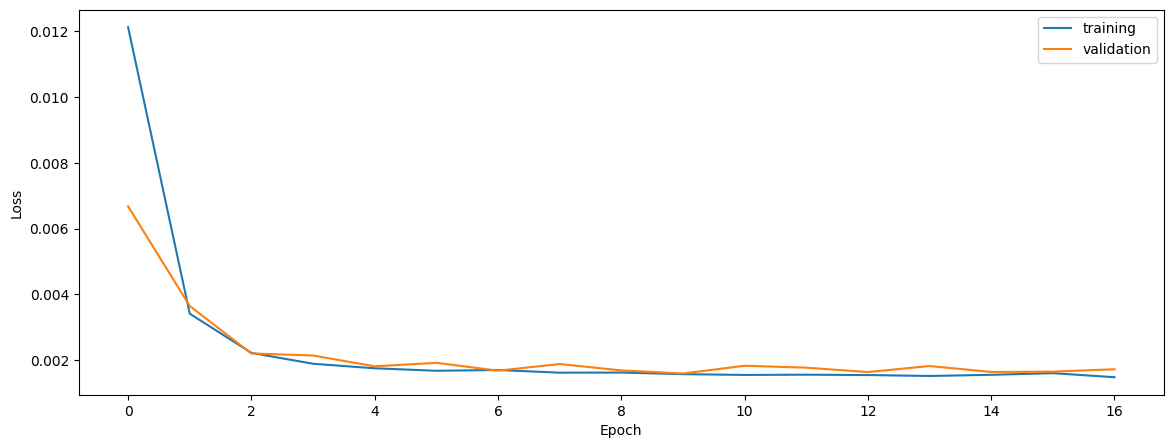

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9377101389579536
0.9513324037105356
0.9415681295545474


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9377101389579536
0.9513324037105356
0.9415681295545474


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.945810232889912
0.9554572748693001
0.9549056921764097


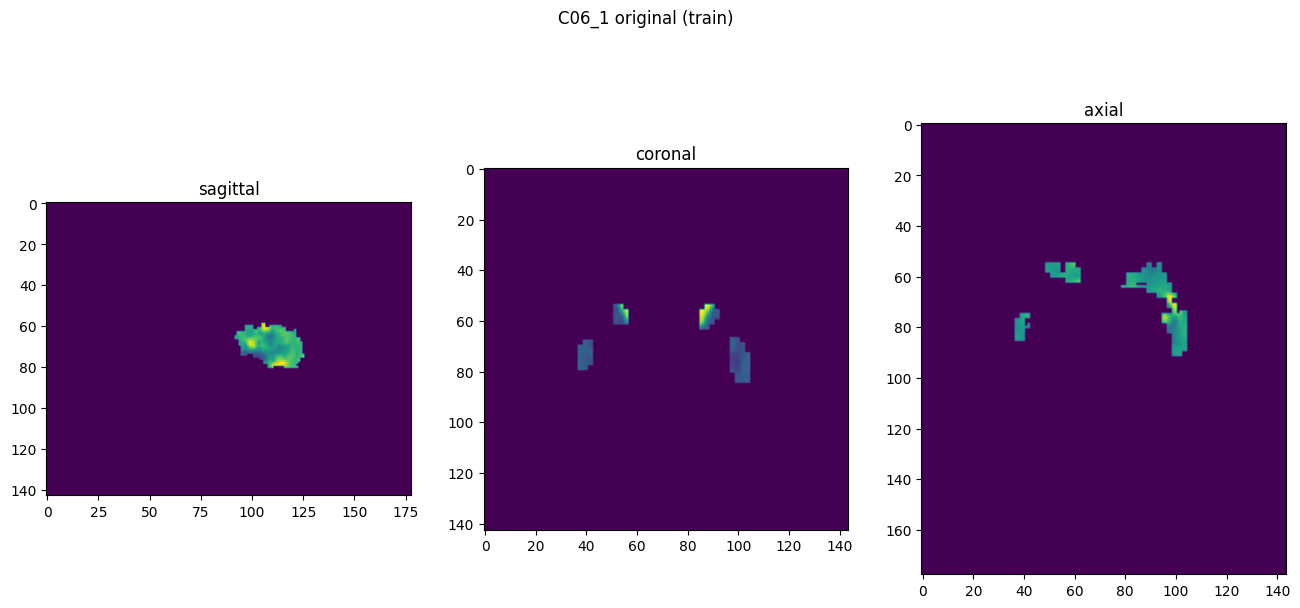

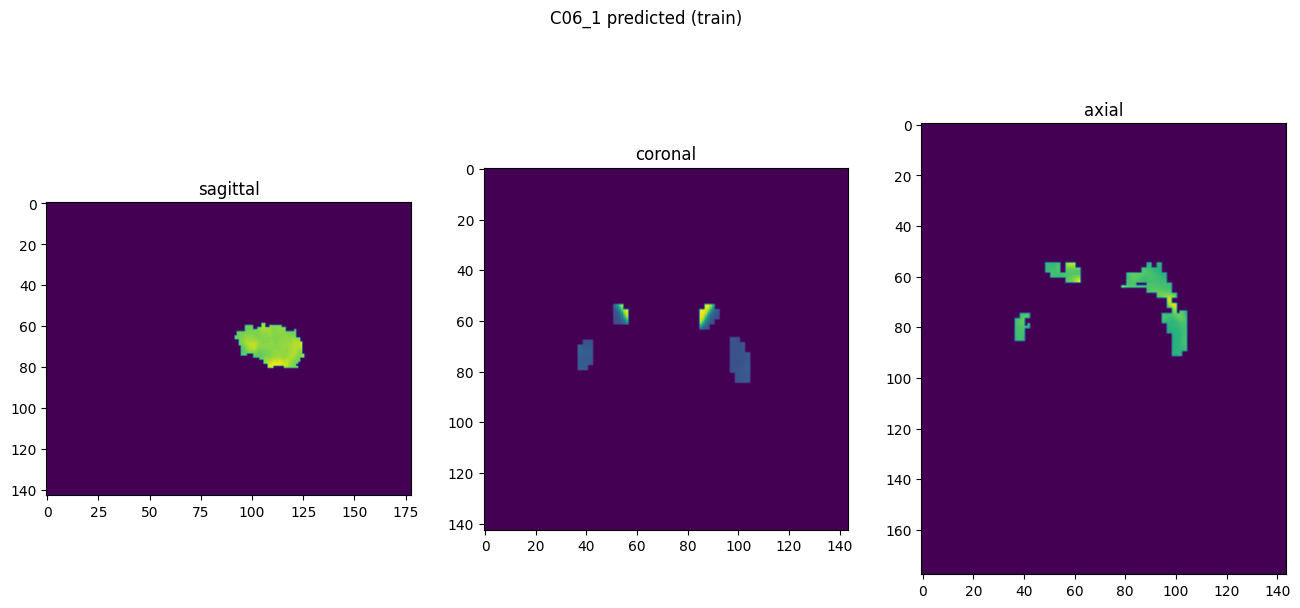

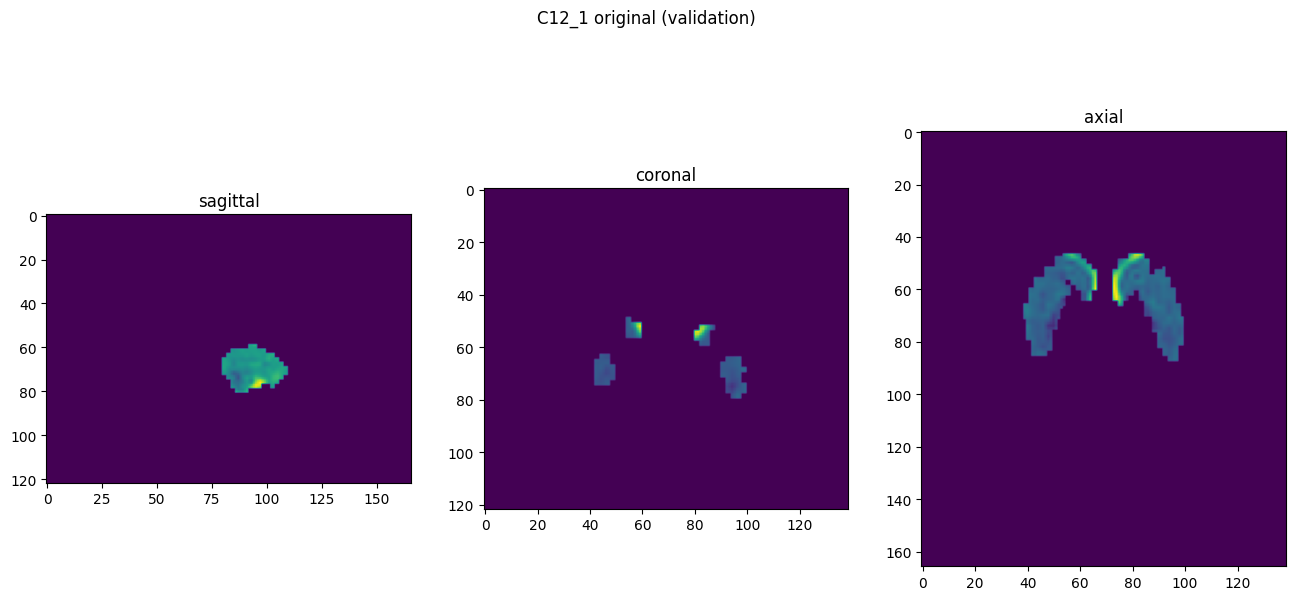

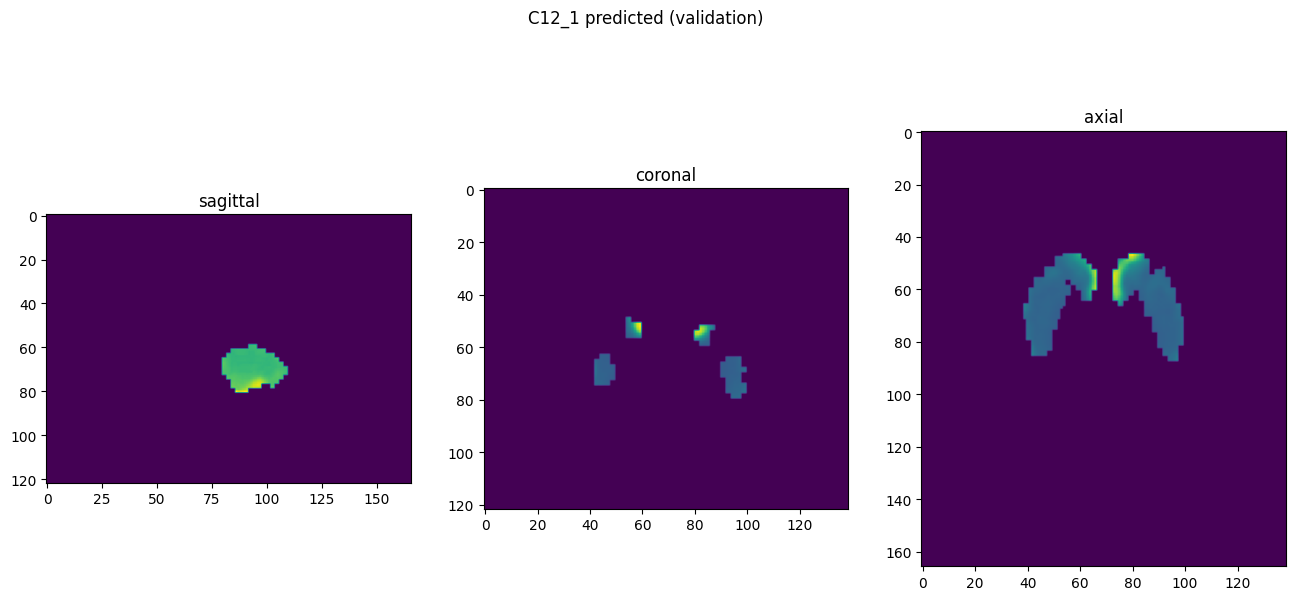

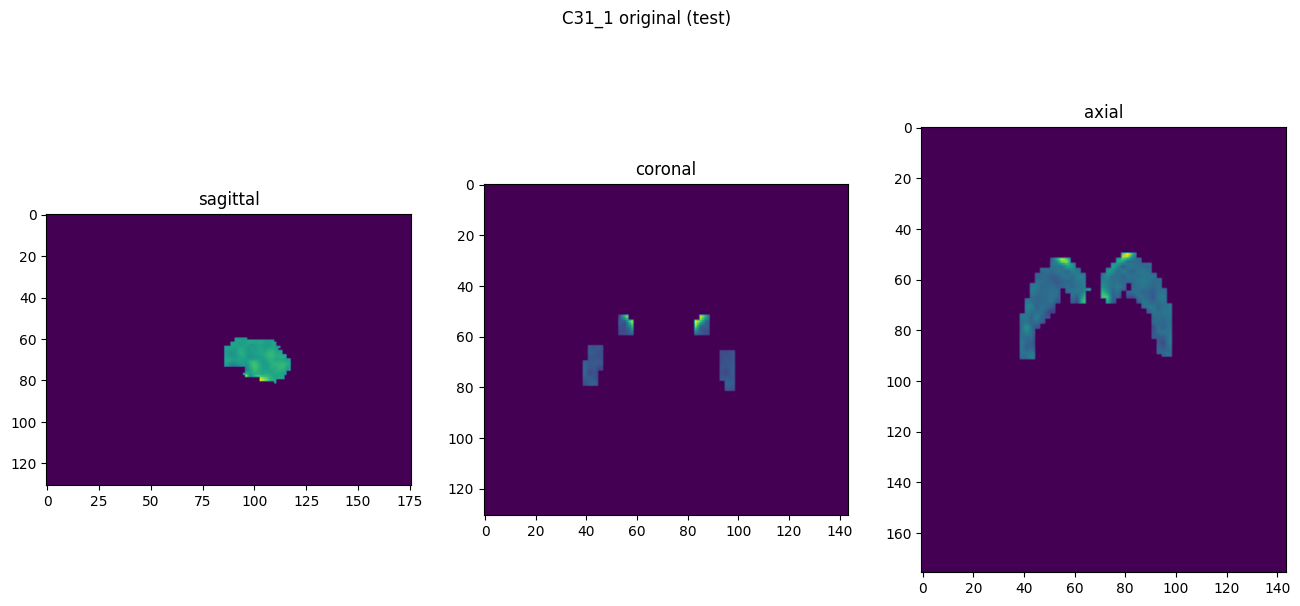

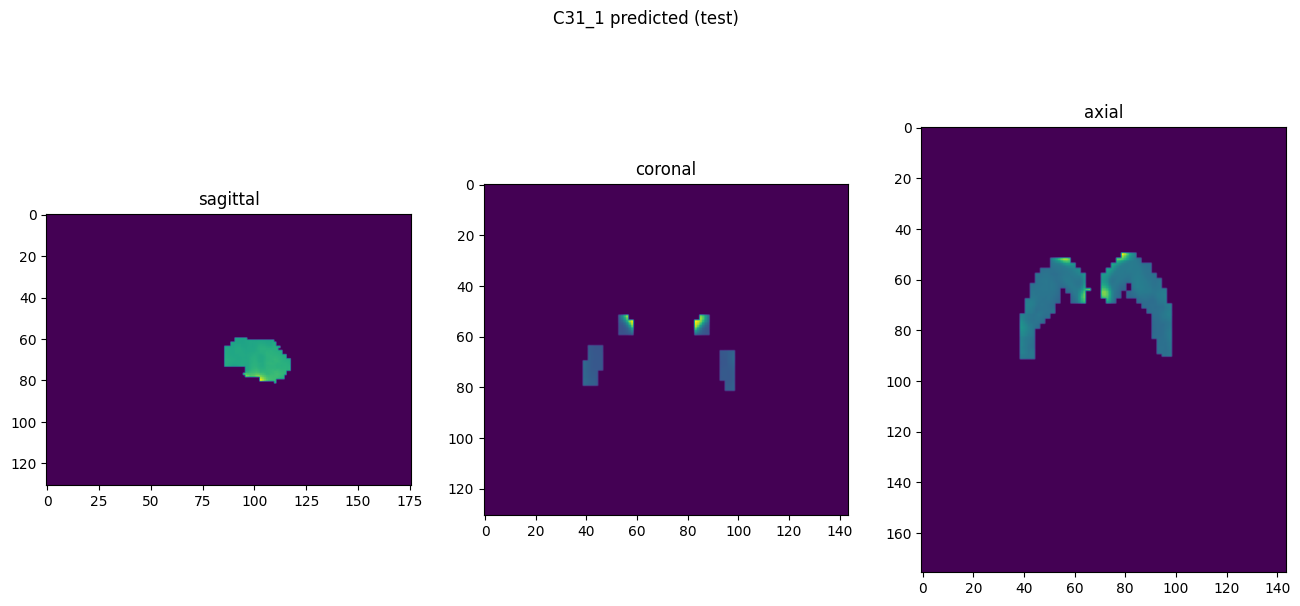

In [10]:
showResults(model, gen, threshold=None, background=False)